# NYC 311 Requests -  Exploratory Data Analysis
### Danielle Medellin


## Problem Statement

According to the NYC311 online portal, "a Service Request is your request for the City to provide you with assistance, perform an inspection, or address a problem. NYC311 can accept Service Requests for a wide range of issues, including over 500 complaint types. Service Requests can help you get a pothole fixed in your neighborhood, the heat turned on in your apartment, or a refund for an overpaid parking ticket." Due to the fact that there are so many different reasons for submitting service requests to 311, all with a wide range of urgency and importance, it can be difficult to gauge how long it will take for a request to actually get resolved.


The NYC 311 receives millions of requests a year! In fact, in 2018 they received 3,154,013 service requests! [Source](https://www1.nyc.gov/311/311-sets-new-record-in-2018.page)

A citizen can submit a 311 request in various ways including by phone, online, or using mobile. If they do so with an email or a phone number, they will get a confirmation message which includes the details of the request. What is not included in this confirmation, is expected wait time until the request will be resolved and closed. Obviously, there are many factors that can affect one's wait time, but given the amount of 311 requests received, it should be possible to find trends in the wait times of these requests and give citizens, at the minimum, an estimate of how long they can expect to wait until their request is resolved. 

Our goal is to build a regression model that will predict the wait time a citizen can expect given the factors of their request. Our model's success will be measured with root-mean squared error (RMSE). 

Additionally, we hope to build an applet protoype that mimics what inputting a service request might look like, and in addition to just getting a description of the request, the app will also return an estimated wait time for the request to be closed.

## Executive Summary

## Data Dictionary

|Feature|Type|Description|
|---|:---:|:---|
|unique_key|int|Unique identifier of a Service Request (SR) in the open data set|
|created_date|datetime|Date and time when SR was submitted|
|closed_date|datetime|Date and time when SR was resolved and closed|
|agency|object|Acronym for agency which responds to the SR|
|agency_name|object|Which agency responds to the SR|
|complaint_type|object|The first level of a hierarchy identifying the topic of the incident or condition. Complaint Type may have a corresponding Descriptor or may stand alone.|
|descriptor|object|Associated to the Complaint Type, and provides further detail on the incident or condition. Descriptor values are dependent on the Complaint Type, and are not always required in SR.|
|location_type|object|Describes the type of location used in the address information|
|status|object|Status of SR at time of data collection. For the purpose of this project, only entries with status 'Closed' were collected|
|borough|object|Name of borough|
|open_data_channel_type|object|Indicates how the SR was submitted to 311.  i.e. By Phone, Online, Mobile, Other or Unknown|
|resolution_description|object|Describes the last action taken on the SR by the responding agency.  May describe next or future steps|
|resolution_action_updated_date|datetime|Date when responding agency last updated SR|
|latitude|float|Latitude in decimal degrees|
|longitude|float|Longitude in decimal degrees|
|waittime|float|Time elapsed from created date to closed date in days|

Data dictionary adapted from [original dataset](https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9).  As explained in the `data_gathering_311` notebook, we collected data from the 311 NYC Open Data API. In order to better serve our purpose and our model, we decided to search specifically for requests that were already closed, and all requests were responded to by the NYPD. Specific details of each column/feature in the data set can be found above. 

## Table of Contents

- [Import Libraries](#Library-Imports)  
- [Load Data](#Import-Data)  
- [Data Cleaning](#Data-Cleaning)  
    - [Null Values](#Checking-for-null-values)  
    - [Wait Time](#Checking-waittime)  
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
    - [k-Modes](#k-Modes) **FIX THIS**

## Library Imports

In [85]:
# if not already installed
# !pip install kmodes

In [133]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from kmodes.kmodes import KModes
import statsmodels.api as sm 
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
import statsmodels.formula.api as smf
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller

# for reproducibility 
RANDOM_STATE = 11714

## Import Data

In [4]:
original = pd.read_csv('../data/service_request.csv')

### Creating Training and Validation Sets

In [5]:
sr, val = train_test_split(original, test_size = .1, random_state = RANDOM_STATE)

In [6]:
sr.shape

(540000, 32)

In [7]:
val.shape

(60000, 32)

In an effort to see how our model works on completely new data, we created a validation (or holdout) set of data. We used only 10% of the data for this validation set, as it is an extra step of measuring our model's success. We will clean this data set in the same ways we clean our training data set, but will not perform any EDA on the validation set.

## Data Cleaning

In [8]:
sr.shape

(540000, 32)

After splitting our data into a validation set, we have 540,000 observations and 32 features. 

In [9]:
sr.dtypes

unique_key                          int64
created_date                       object
closed_date                        object
agency                             object
agency_name                        object
complaint_type                     object
descriptor                         object
location_type                      object
status                             object
community_board                    object
borough                            object
open_data_channel_type             object
park_facility_name                 object
park_borough                       object
incident_zip                      float64
incident_address                   object
street_name                        object
cross_street_1                     object
cross_street_2                     object
intersection_street_1              object
intersection_street_2              object
city                               object
landmark                           object
bbl                               

As seen above we have many features, some of which will not be helpful to us or we will not use. For example, anything pertaining to a _specific_ address or location will not be used such as `incident_address` or `incident_zip` as these factors can often be indicators of other features such as race or socioeconomic status. Instead, we will simply keep `borough` as it is a large enough bucket with diverse populations. We will keep `longitude` and `latitude` for visualization purposes, but it will not be included in the model itself. Some of the features listed above are repetitive, such as `x_coordinate_state_plane`, as it will serve the same purpose as `latitude`. Features like `cross_street_1` or `intersection_street_1` are not needed for our purposes, as these featuers are usually used to help the responding agency find the source of the request. Since we aren't focusing on exact locations, we will not need these features. 


Two features that are important to us are the `created_date` and `closed_date` columns, which are currently being read as objects. We will convert these to datetime.  

Many of the remaining columns are categorical ones, such as `location_type`, which we expect to have null values for. We will fill all null values for these types of features with either `unknown` or `none` as it still gives us the same information, but will be able to be used in our visuals and models. 

In [10]:
def clean_dataframe(train, holdout):
    for df in [train, holdout]: # clean both dfs at once
        
        df.drop_duplicates(inplace=True)
        
        # convert columns to datetime
        for col in ['created_date', 'closed_date', 'resolution_action_updated_date']:
            df[col] = pd.to_datetime(df[col])
        
        
        # fill empty descriptions with 'none'
        df['descriptor'].fillna('none', inplace=True)
        
        df['resolution_description'].fillna('none', inplace=True) 
        
        # fill empty location types with unknown
        df['location_type'] = df['location_type'].fillna('unknown')
        
        # drop columns that are repetitive and will not be useful to the model 
        df.drop(columns=['landmark','intersection_street_1','cross_street_1',
                         'cross_street_2','intersection_street_2',
                        'community_board','incident_zip','incident_address',
                        'street_name','bbl','x_coordinate_state_plane',
                        'y_coordinate_state_plane','city','park_borough',
                        'park_facility_name','location'], inplace=True)
        
   


The above function will take in both the training and validation set and clean them as discussed above, dropping necessary columns and filling in null values where appropriate. 

In [11]:
# cleaning both dataframes at once
clean_dataframe(sr, val)

/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

In [12]:
# check to see if appropriate columns have been dropped 
sr.columns

Index(['unique_key', 'created_date', 'closed_date', 'agency', 'agency_name',
       'complaint_type', 'descriptor', 'location_type', 'status', 'borough',
       'open_data_channel_type', 'latitude', 'longitude',
       'resolution_description', 'resolution_action_updated_date', 'waittime'],
      dtype='object')

### Checking for null values

In [13]:
sr.isnull().sum().sort_values()

unique_key                            0
created_date                          0
closed_date                           0
agency                                0
agency_name                           0
complaint_type                        0
descriptor                            0
location_type                         0
status                                0
borough                               0
open_data_channel_type                0
resolution_description                0
waittime                              0
resolution_action_updated_date      178
latitude                          10978
longitude                         10978
dtype: int64

In [14]:
sr[sr['resolution_action_updated_date'].isnull()]['resolution_description'].value_counts()

Your complaint has been forwarded to the New York Police Department for a non-emergency response. Your complaint will take priority over other non-emergency complaints. 311 will have additional information in 8 hours. Please note your service request number for future reference.                                                                                                                                                                                                                               155
Your complaint has been forwarded to the New York Police Department for a non-emergency response. If the police determine the vehicle is illegally parked, they will ticket the vehicle and then you may either contact a private towing company to remove the vehicle or ask your local precinct to contact 'rotation tow'. Any fees charged for towing will have to be paid by the vehicle owner. 311 will have additional information in 8 hours. Please note your service request number for future refere

The only columns remaining with null values are `longitude`, `latitude`, and `resolution_action_updated_date`. Because we will not be using `longitude` and `latitude` in our model, but just for visualization purposes, we will keep these null values as is. After some exploration, it was shown that requests with a null value for `resolution_action_updated_date` often had a `resolution_description` that informed the civilian that their request was in fact forwarded to the NYPD, non-emergent, and more information would be available within 8 hours. Unfortunately, these were never updated.

### Checking `waittime`

In [16]:
sr[sr['waittime'] < 0].head()

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,location_type,status,borough,open_data_channel_type,latitude,longitude,resolution_description,resolution_action_updated_date,waittime
180229,44212516,2019-11-03 01:16:04,2019-11-03 01:10:20,NYPD,New York City Police Department,Homeless Encampment,none,Store/Commercial,Closed,MANHATTAN,ONLINE,40.709304,-74.005295,The Police Department responded to the complai...,2019-11-03 06:10:25,-1.996019
180012,44209266,2019-11-03 01:57:58,2019-11-03 01:52:37,NYPD,New York City Police Department,Noise - Commercial,Loud Music/Party,Store/Commercial,Closed,BROOKLYN,MOBILE,40.716626,-73.961798,The Police Department responded to the complai...,2019-11-03 06:52:45,-1.996285
180151,44210509,2019-11-03 01:30:57,2019-11-03 01:07:57,NYPD,New York City Police Department,Homeless Encampment,none,Store/Commercial,Closed,MANHATTAN,ONLINE,40.709954,-74.008999,The Police Department responded to the complai...,2019-11-03 06:07:58,-1.984028
180050,44215330,2019-11-03 01:49:02,2019-11-03 01:21:44,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,Closed,QUEENS,PHONE,40.740511,-73.919239,The Police Department responded to the complai...,2019-11-03 06:21:51,-1.981042
180141,44212550,2019-11-03 01:32:28,2019-11-03 01:21:24,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,Closed,QUEENS,ONLINE,40.740511,-73.919239,The Police Department responded to the complai...,2019-11-03 06:21:32,-1.992315


There were 16 observations that had a negative wait time, which doesn't make any sense. After further investigation, it was found that these particular requests were all made on the same day, 2019-11-03, within the 1 am hour. There were varying boroughs and submission types, so no pattern was found there. All complaints were either a noise complaint or related to a homeless encampment. There were other requests made on this day that did not seem to have this error. Being these entries make up less than .01% of the whole dataset, we will simply drop these rows from the training set. We understand that if this same error occurs in the validation set, we will not be able to drop said rows, but are hoping this was a one time error in data collection and that these errors will make up only a small portion of the whole dataset to not effect it too strongly.

In [17]:
# drop negative waittimes 
indices_to_drop = sr[sr['waittime'] < 0].index
sr.drop(index=indices_to_drop, inplace=True)
sr.shape

/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(539984, 16)

## Exploratory Data Analysis

In [18]:
sr['waittime'].describe()

count    539984.000000
mean          0.442553
std           3.493269
min           0.000197
25%           0.058032
50%           0.133848
75%           0.274436
max         206.016285
Name: waittime, dtype: float64

The average wait time is 0.4426 days, with a standard deviation of 3.493 days. The maximum wait time in this dataset is over 206 days. The 75th percentile, though, is still less than one day at 0.274, showing that longer wait times are unexpected and rarer. 

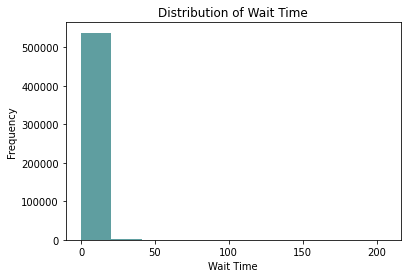

In [19]:
plt.hist((sr['waittime']), color = 'cadetblue')
plt.title('Distribution of Wait Time')
plt.xlabel('Wait Time')
plt.ylabel('Frequency');

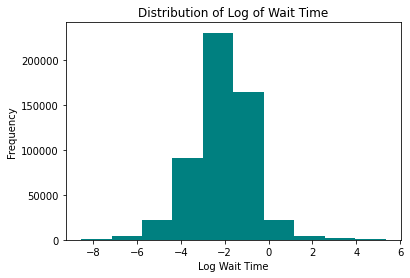

In [20]:
plt.hist(np.log(sr['waittime']), color = 'teal')
plt.title('Distribution of Log of Wait Time')
plt.xlabel('Log Wait Time')
plt.ylabel('Frequency');

When looking at the distribution of wait time, the original distribution was very skewed, due to the rare wait times discussed previously. In order to have a target variable that is closer to being normally distributed, we took the log of the wait times. In our model, we will use the log of our target variable. 

In [21]:
def plot_pct_waittime(y, pct_width, avg_width, colors, y_label):
    """
    Plots 2 horizontal bar charts, the first showing the percentage breakdown of each category in feature. The second showing the average wait time for each category.
    
    Parameters:
    y: labels for y axis
    pct_width: values for percentage break down
    avg_width: values for wait time averages
    colors: takes list of colors (min 2)
    y_label: y label for graphs
    """
    
    fig, axes = plt.subplots(figsize=(14,5), ncols=2)

    axes[0].set_title(f'Percentage of Most Frequent {y_label}s',size=16)
    axes[0].barh(y=y, width=pct_width, color=colors[0])
    axes[0].set_ylabel(y_label,size=13)
    axes[0].set_xlabel('Percentage',size=13)
    
    axes[1].set_title(f'Average Wait Time (Days) by {y_label}',size=16)
    axes[1].barh(y=y, width=avg_width, color=colors[1])
    axes[1].set_ylabel(y_label,size=13)
    axes[1].set_xlabel('Average Wait Time (Days)',size=13)
    
    fig.tight_layout();
    

In [22]:
sr['complaint_type'].value_counts(normalize=True)

Noise - Residential            0.267063
Illegal Parking                0.239711
Blocked Driveway               0.158634
Noise - Street/Sidewalk        0.128824
Noise - Vehicle                0.050526
Abandoned Vehicle              0.046461
Noise - Commercial             0.042799
Non-Emergency Police Matter    0.012447
Homeless Encampment            0.010165
Animal-Abuse                   0.008204
Vending                        0.005991
Traffic                        0.005369
Noise - Park                   0.004985
Panhandling                    0.003817
Drug Activity                  0.003635
Derelict Vehicle               0.002706
Drinking                       0.002206
Illegal Fireworks              0.001515
Bike/Roller/Skate Chronic      0.000883
Graffiti                       0.000880
Homeless Street Condition      0.000867
Noise - House of Worship       0.000824
Urinating in Public            0.000770
Animal Abuse                   0.000487
Disorderly Youth               0.000117


The top two complaint types for these service requests were 'Noise - Residential' (26.7%) and 'Illegal Parking' (23.9%), together making up more than half of the complaints. The next two most frequent complaints were 'Blocked Driveway' (15.9%) and 'Noise - Street/Sidewalk' (12.9%). Each of the remainder of the complaint types make up about 5% or less per complaint type. Of the 27 different complaint types, 6 were associated with some type of noise complaint.

In [23]:
top_10_complaints = sr['complaint_type'].value_counts(normalize=True)[:10].index
complaint_mean_waittimes = sr.groupby('complaint_type')['waittime'].mean()

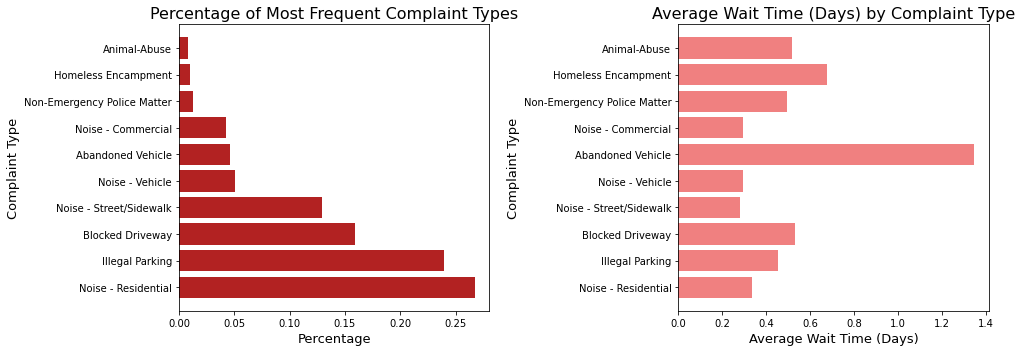

In [24]:
plot_pct_waittime(top_10_complaints,
                  sr['complaint_type'].value_counts(normalize=True)[:10],
                  complaint_mean_waittimes[top_10_complaints],
                  ['firebrick','lightcoral'],
                  'Complaint Type')

**Note:** the complaint types are listed in ascending order, where _Noise - Residential_ is the most frequent complaint type. The top 3 most frequent complaint types had average wait times between 0.3 and 0.6 days. In fact, out of the top 10 most frequent complaint types, the only one that had an average wait time of more than one day was _abandoned vehicle._ 

In [25]:
borough_counts = sr['borough'].value_counts(normalize=True)[:5]
borough_counts

BROOKLYN         0.310991
QUEENS           0.273669
MANHATTAN        0.197991
BRONX            0.181142
STATEN ISLAND    0.035720
Name: borough, dtype: float64

In [26]:
borough_mean = sr.groupby('borough')['waittime'].mean()[:5]
borough_mean

borough
BRONX            0.519340
BROOKLYN         0.378689
MANHATTAN        0.188548
QUEENS           0.600875
STATEN ISLAND    0.224443
Name: waittime, dtype: float64

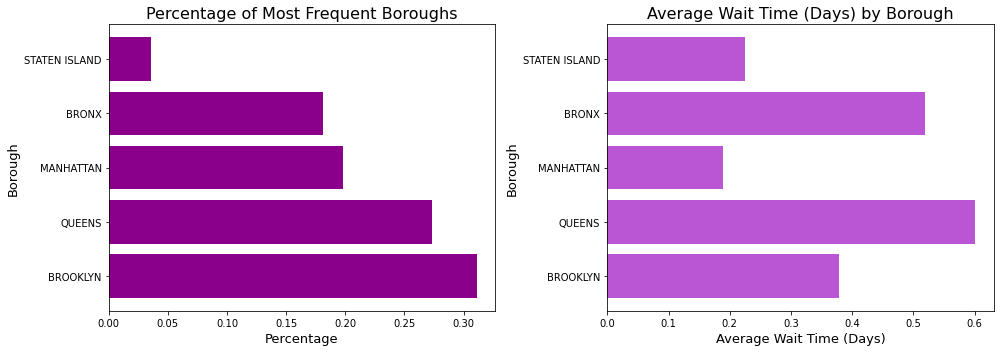

In [27]:
plot_pct_waittime(borough_counts.index,
                  borough_counts,
                  borough_mean[borough_counts.index],
                  ['darkmagenta','mediumorchid'],
                  'Borough')

*Note: Unspecified is another option for `borough` but made up less than 1% of the data so it is not included in this graph.*   
Queens had the highest average wait time with roughly 0.6 days, followed by the Bronx with 0.52 days. Manhattan had the lowest average wait time of 0.19 days. All boroughs had an average wait time of 0.6 days or less. 

In [28]:
submission_types = sr['open_data_channel_type'].value_counts(normalize=True)[:3]
submission_types

PHONE     0.424642
ONLINE    0.291010
MOBILE    0.284255
Name: open_data_channel_type, dtype: float64

In [29]:
submission_means = sr.groupby('open_data_channel_type')['waittime'].mean()

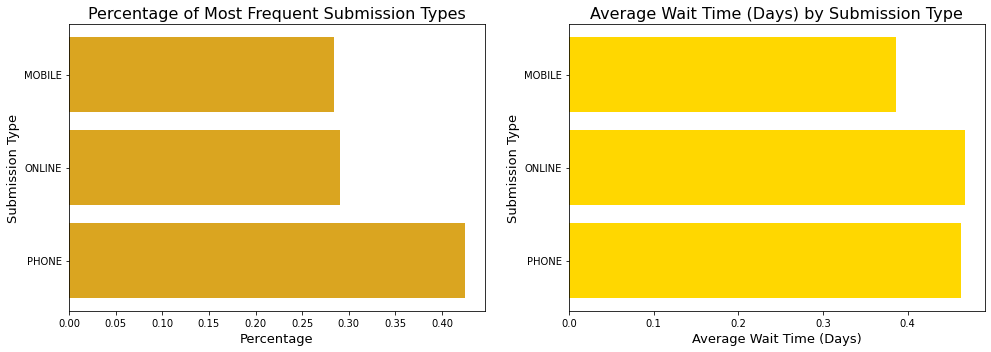

In [30]:
plot_pct_waittime(submission_types.index,
                  submission_types,
                  submission_means[submission_types.index],
                  ['goldenrod','gold'],
                  'Submission Type')

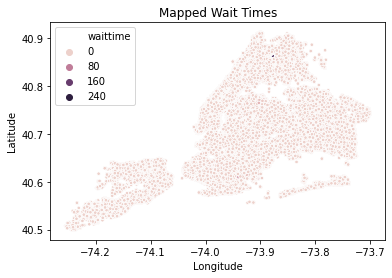

In [31]:
sns.scatterplot(data = sr, y='latitude', x = 'longitude', s=12,hue = 'waittime')
plt.title('Mapped Wait Times')
plt.ylabel('Latitude')
plt.xlabel('Longitude');

In [32]:
sr[sr['complaint_type']=='Noise - Residential']['descriptor'].value_counts(normalize=True)

Loud Music/Party    0.643506
Banging/Pounding    0.274530
Loud Talking        0.063775
Loud Television     0.018189
Name: descriptor, dtype: float64

In [33]:
sr[sr['complaint_type']=='Noise - Residential'].groupby('descriptor')['waittime'].mean()

descriptor
Banging/Pounding    0.365132
Loud Music/Party    0.329723
Loud Talking        0.276959
Loud Television     0.301759
Name: waittime, dtype: float64

In [34]:
sr[sr['complaint_type']=='Illegal Parking']['descriptor'].value_counts(normalize=True)

Posted Parking Sign Violation     0.253708
Blocked Hydrant                   0.239030
Blocked Sidewalk                  0.141749
Commercial Overnight Parking      0.125471
Blocked Bike Lane                 0.101252
Double Parked Blocking Traffic    0.056683
Double Parked Blocking Vehicle    0.033181
Parking Permit Improper Use       0.020465
Unauthorized Bus Layover          0.013334
Overnight Commercial Storage      0.011573
Detached Trailer                  0.003554
Name: descriptor, dtype: float64

In [35]:
sr[sr['complaint_type']=='Illegal Parking'].groupby('descriptor')['waittime'].mean()

descriptor
Blocked Bike Lane                 0.275404
Blocked Hydrant                   0.404650
Blocked Sidewalk                  0.522839
Commercial Overnight Parking      0.573481
Detached Trailer                  0.652295
Double Parked Blocking Traffic    0.384704
Double Parked Blocking Vehicle    0.356336
Overnight Commercial Storage      0.573419
Parking Permit Improper Use       0.556114
Posted Parking Sign Violation     0.485996
Unauthorized Bus Layover          0.297383
Name: waittime, dtype: float64

Since there is virtually no data for unknown and other we won't graph it. 

In [36]:
sr.describe(include=np.object).T

,count,unique,top,freq
agency,539984,1,NYPD,539984
agency_name,539984,2,New York City Police Department,539937
complaint_type,539984,27,Noise - Residential,144210
descriptor,539984,49,Loud Music/Party,168693
location_type,539984,22,Street/Sidewalk,305150
status,539984,1,Closed,539984
borough,539984,6,BROOKLYN,167930
open_data_channel_type,539984,5,PHONE,229300
resolution_description,539984,22,The Police Department responded to the complai...,182488


In [65]:
# def change_waittime(df):
#     for i in df.index:
#         if df.loc[i,'created_date'] <= df.loc[i,'closed_date']:
#             difference = df.loc[i,'closed_date'] - df.loc[i,'created_date']
#             df.loc[i,'waittime'] = conv_to_days(difference)
#         
#         else:
#             difference = df.loc[i,'created_date'] - df.loc[i,'closed_date']
#             df.loc[i,'waittime'] = conv_to_days(difference) * -1
#         

## $k$-Modes

[Source 2](https://shapeofdata.wordpress.com/2014/03/04/k-modes/)

In [37]:
# source: https://github.com/nicodv/kmodes/blob/master/examples/soybean.py
# set up X, y
features=['complaint_type','descriptor','location_type','borough','open_data_channel_type']
exog = sr[features]
endog = sr['waittime']

In [26]:
# source: https://www.kaggle.com/ashydv/bank-customer-clustering-k-modes-clustering

cost = [] # empty list for cost values
for num_clusters in list(range(2,9)): # testing n_clusters 2 - 8
    kmode = KModes(n_clusters=num_clusters, init = "Cao", n_init = 1, verbose=1)
    kmode.fit_predict(exog)
    cost.append(kmode.cost_)

KeyboardInterrupt: 

In [38]:
q = np.array([i for i in range(2,9,1)])
plt.plot(q,cost)
plt.ylabel('Cost', size=12)
plt.xlabel('Number of Clusters',size=12)
plt.title('Cost per Number of Clusters',size=16);

NameError: name 'cost' is not defined

In order to choose our $k$ value, we will look to minimize the cost function. We tested values of $k$ from 2 - 8 to see which gave us the best cost value. Those results are shown above. Since the cost value does not decrease, but instead almost levels out between 5 and 6 clusters, we will use 5 as our cluster value for our $k$-Modes model.  

In [39]:
km_cao = KModes(n_clusters=5, init = "Cao", verbose=1)
fitClusters_cao = km_cao.fit_predict(exog)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 78498, cost: 1068774.0
Run 1, iteration: 2/100, moves: 27961, cost: 1068774.0


In [40]:
km_cao.cost_

1068774.0

In [41]:
# setting up data frames to add predicted clusters from k-modes
sr_ = sr.copy().reset_index()
clusters_df = pd.DataFrame(fitClusters_cao)
clusters_df.columns = ['cluster_predicted']

In [42]:
# creating new data frame with cluster predictions data
new_sr = pd.concat([sr_, clusters_df], axis=1).reset_index()
new_sr.drop(columns=['level_0'],inplace=True)

In [43]:
km_cao.cluster_centroids_

array([['Noise - Street/Sidewalk', 'Loud Music/Party', 'Street/Sidewalk',
        'BROOKLYN', 'PHONE'],
       ['Noise - Residential', 'Loud Music/Party',
        'Residential Building/House', 'QUEENS', 'ONLINE'],
       ['Illegal Parking', 'Posted Parking Sign Violation',
        'Street/Sidewalk', 'QUEENS', 'MOBILE'],
       ['Blocked Driveway', 'No Access', 'Street/Sidewalk', 'QUEENS',
        'PHONE'],
       ['Illegal Parking', 'Blocked Hydrant', 'Street/Sidewalk',
        'MANHATTAN', 'PHONE']], dtype='<U29')

The 5 clusters below were created from our $k$-modes model:  
_Features: `complaint_type`, `descriptor`, `location_type`, `borough`, `open_data_channel_type`_

0. 'Noise - Street/Sidewalk', 'Loud Music/Party', 'Street/Sidewalk', 'BROOKLYN', 'PHONE',
1. 'Noise - Residential', 'Loud Music/Party', 'Residential Building/House', 'QUEENS', 'ONLINE'
2. 'Illegal Parking', 'Posted Parking Sign Violation', 'Street/Sidewalk', 'QUEENS', 'MOBILE'
3. 'Blocked Driveway', 'No Access', 'Street/Sidewalk', 'QUEENS', 'PHONE'
4. 'Illegal Parking', 'Blocked Hydrant', 'Street/Sidewalk','MANHATTAN', 'PHONE'

While every observation in each cluster will not match these results exactly, these requests were found to be most similar to one another. 

Cluster 0 seems to focus on noise complaints made by phone that occur on the sidewalk or street, mainly in Brooklyn. We will rename this cluster `Noise Brooklyn`.

Cluster 1 focuses on noise complaints made online that occur in a residential building or house, mostly in Queens. We will rename this cluster `Noise Queens`.

Cluster 2 focuses on requests about illegal parking involving parking sign violations mostly in Queens, made via mobile. We will rename this cluster `Parking Queens`. 

Cluster 3 focuses on blocked driveways mostly in Queens, made via phone. We will rename this cluster `Driveway Queens`. 

Cluster 4 focuses on requests about illegal parking involving blocked fire hydrants, mostly in Manhattan and made via phone. We will rename this cluster `Parking Manhattan`. 


In [44]:
# renaming 'cluster_predicted' values 
cluster_names = {
    0: 'Noise Brooklyn',
    1: 'Noise Queens',
    2: 'Parking Queens',
    3: 'Driveway Queens',
    4: 'Parking Manhattan'
}

new_sr['cluster_predicted'] = new_sr['cluster_predicted'].map(cluster_names)
clusters = new_sr['cluster_predicted'].value_counts(normalize=True)

In [45]:
# finding average wait time for each cluster 
cluster_means = new_sr.groupby('cluster_predicted')['waittime'].mean()
cluster_means

cluster_predicted
Driveway Queens      0.594756
Noise Brooklyn       0.388189
Noise Queens         0.419284
Parking Manhattan    0.283548
Parking Queens       0.512238
Name: waittime, dtype: float64

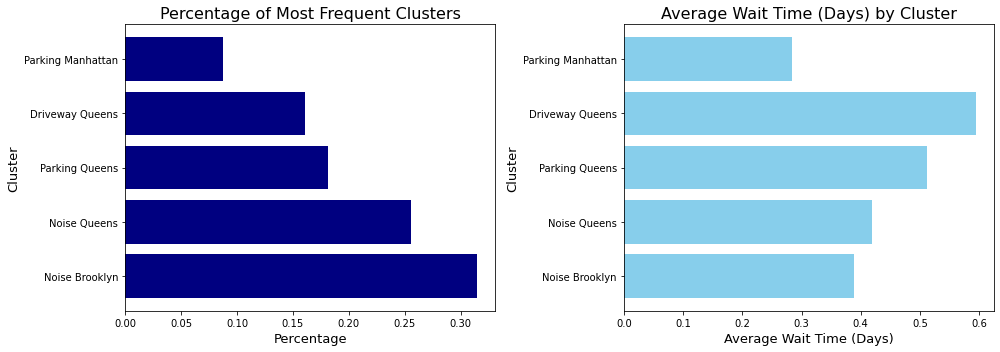

In [46]:
plot_pct_waittime(clusters.index,
                  clusters,
                  cluster_means[clusters.index],
                  ['navy','skyblue'],
                  'Cluster')

Three of the 5 clusters were focused in Queens, the second most frequent borough overall. The cluster with the most observations was the `Noise Brooklyn` cluster, while the cluster with the least amount of observations  was the `Parking Manhattan` cluster. Both the Bronx and Staten Island were not considered a centroid for any cluster. They were the two least common boroughs in the data set. All three clusters related to _Queens_ had the highest average wait times. The `Driveway Queens` cluster had the highest average wait time of just under 0.6 days. The cluster with the lowest average wait time was the `Parking Manhattan` cluster with just under 0.3 days. 


## Model Preparation

### Dummy Variables

In [47]:
new_features = ['complaint_type',
 'descriptor',
 'location_type',
 'borough',
 'open_data_channel_type', 'cluster_predicted']

In [48]:
dummy_sr = new_sr[new_features]
dummy_sr = pd.get_dummies(dummy_sr, columns=new_features, drop_first=True)
dummy_sr.head()

,complaint_type_Animal Abuse,complaint_type_Animal-Abuse,complaint_type_Bike/Roller/Skate Chronic,complaint_type_Blocked Driveway,complaint_type_Derelict Vehicle,complaint_type_Disorderly Youth,complaint_type_Drinking,complaint_type_Drug Activity,complaint_type_Graffiti,complaint_type_Homeless Encampment,...,borough_STATEN ISLAND,borough_Unspecified,open_data_channel_type_ONLINE,open_data_channel_type_OTHER,open_data_channel_type_PHONE,open_data_channel_type_UNKNOWN,cluster_predicted_Noise Brooklyn,cluster_predicted_Noise Queens,cluster_predicted_Parking Manhattan,cluster_predicted_Parking Queens
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [49]:
# set up X and y
X = dummy_sr
y = new_sr['waittime']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)

In [50]:
X.isnull().sum().sum()

0

In [51]:
y.isnull().sum()

0

#### RMSE Function

In [32]:
# function to find RMSE 
def find_rmse(model, X, y):
    preds = model.predict(X)
    # important to exponentiate here because we used log(y)
    mse = metrics.mean_squared_error(np.exp(y), np.exp(preds))
    rmse = np.sqrt(mse)
    return rmse

In [73]:
# source: Mahdi Shadkam-Farrokhi, https://git.generalassemb.ly/DSI-US-11/local_faq/blob/master/code/custom_cross_val_score.ipynb

# function to find RMSE 
def rmse(y_true, y_pred): # this signature matters for later use with `make_scorer`
    '''Returns the root mean squared error'''
    return np.sqrt(mean_squared_error(y_true, y_pred))


def rmse_log(y_true, y_pred): # this signature matters for later use with `make_scorer`
    '''Returns the root mean squared error'''
    return np.sqrt(mean_squared_error(np.exp(y_true), np.exp(y_pred)))

## Modeling 

### Baseline Model

In [53]:
dummy = DummyRegressor(strategy='mean')
dummy.fit(X_train, y_train)
dummy_tr_preds = dummy.predict(X_train) 
dummy_te_preds = dummy.predict(X_test)

In [54]:
print(f'Train:', rmse(y_train, dummy_tr_preds))
print(f'Test:', rmse(y_test, dummy_te_preds))
print(f'Cross Val:', cross_val_score(dummy, X, y, scoring=make_scorer(rmse), cv=5).mean())
print(f'Difference: {rmse(y_test, dummy_te_preds) - rmse(y_train, dummy_tr_preds)}')

Train: 3.434612969465482
Test: 3.663597253566948
Cross Val: 3.4801403506230644
Difference: 0.22898428410146598


Our most basic model is performing with a testing RMSE of 3.66 days. Being that the overwhelming majority of our data target variable was less than 1 day, this is showing a pretty wide margin of error. Additionally, the training score (3.43) is lower than the testing score indicating our model is overfit. 

### Linear Regression

Because the distribution of our target variable is so heavily skewed, we will be using the log of the target variable as its distribution is much closer to a normal distribution. 

In [71]:
lr = LinearRegression()
lr.fit(X_train,np.log(y_train))
lr_tr_preds = lr.predict(X_train)
lr_te_preds = lr.predict(X_test)

In [74]:
print(f'Train:', rmse(y_train, np.exp(lr_tr_preds)))
print(f'Test:', rmse(y_test, np.exp(lr_te_preds)))
print(f'Cross Val:', cross_val_score(lr, X, np.log(y), scoring=make_scorer(rmse_log), cv=5).mean())
print(f'Difference: {rmse(y_test, np.exp(lr_te_preds)) - rmse(y_train, np.exp(lr_tr_preds))}')

Train: 3.4294227534585238
Test: 3.6581897802501
Cross Val: 3.474520667350503
Difference: 0.22876702679157646


Our linear regression model is performing at essentially the same level as our baseline model. The training (3.43) and testing (3.66) scores are virtually the same with a very similar difference in the scores (.229), again showing overfitting in the model. As our model is showing increased variance, we will move to a regularization method of LASSO. 

### LASSO

In [67]:
# Set up a list of Lasso alphas to check.
l_alphas = np.logspace(-5,-2,60)

# Cross-validate over our list of Lasso alphas.
lasso_cv = LassoCV(alphas=l_alphas,
                 cv=5)

# Fit model using best ridge alpha!
lasso_cv.fit(X_train, np.log(y_train))
lasso_cv.alpha_

/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36379.58719858795, tolerance: 73.21284186829253
  positive)


2.2695105366946683e-05

In [68]:
l_alphas

array([1.00000000e-05, 1.12421004e-05, 1.26384820e-05, 1.42083083e-05,
       1.59731228e-05, 1.79571449e-05, 2.01876025e-05, 2.26951054e-05,
       2.55140652e-05, 2.86831681e-05, 3.22459055e-05, 3.62511705e-05,
       4.07539297e-05, 4.58159767e-05, 5.15067808e-05, 5.79044398e-05,
       6.50967523e-05, 7.31824222e-05, 8.22724134e-05, 9.24914728e-05,
       1.03979842e-04, 1.16895182e-04, 1.31414736e-04, 1.47737765e-04,
       1.66088278e-04, 1.86718109e-04, 2.09910372e-04, 2.35983347e-04,
       2.65294846e-04, 2.98247129e-04, 3.35292415e-04, 3.76939098e-04,
       4.23758716e-04, 4.76393801e-04, 5.35566692e-04, 6.02089449e-04,
       6.76875001e-04, 7.60949669e-04, 8.55467254e-04, 9.61724871e-04,
       1.08118075e-03, 1.21547425e-03, 1.36644835e-03, 1.53617495e-03,
       1.72698329e-03, 1.94149195e-03, 2.18264473e-03, 2.45375111e-03,
       2.75853162e-03, 3.10116893e-03, 3.48636523e-03, 3.91940677e-03,
       4.40623643e-03, 4.95353521e-03, 5.56881399e-03, 6.26051657e-03,
      

In [69]:
lasso_tr_preds = lasso_cv.predict(X_train)
lasso_te_preds = lasso_cv.predict(X_test)

In [77]:
print(f'Train:', rmse(y_train, np.exp(lasso_tr_preds)))
print(f'Test:', rmse(y_test, np.exp(lasso_te_preds)))
print(f'Cross Val:', cross_val_score(lasso_cv, X, np.log(y), scoring=make_scorer(rmse_log), cv=5).mean())
print(f'Difference: {rmse(y_test, np.exp(lasso_te_preds)) - rmse(y_train, np.exp(lasso_tr_preds))}')

Train: 3.430711721977498
Test: 3.660159970253172


/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 68.7046358906664, tolerance: 62.07667044847484
  tol, rng, random, positive)
/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 67.03788441536017, tolerance: 62.07667044847484
  tol, rng, random, positive)
/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18957.15805072477, tolerance: 77.8055014582907
  positive)
/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not co

Cross Val: 3.4762375128047127
Difference: 0.22944824827567434


/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18476.36416338454, tolerance: 78.04543858132027
  positive)


### Decision Tree

In [78]:
tree = DecisionTreeRegressor()

# construct paramters
tree_params = {
    'max_depth' : [3],
    'max_features' : [5],
    'min_samples_leaf' : [4]
}

 # Perform Grid Search
gs = GridSearchCV(tree, 
                 param_grid=tree_params,
                 cv = 5,
                 scoring = make_scorer(rmse))
tree = gs.fit(X_train, y_train)

In [79]:
tree.best_params_

{'max_depth': 3, 'max_features': 5, 'min_samples_leaf': 4}

In [80]:
tree_tr_preds = tree.predict(X_train)
tree_te_preds = tree.predict(X_test)

In [81]:
print(f'Train:', rmse(y_train, tree_tr_preds))
print(f'Test:', rmse(y_test, tree_te_preds))
print(f'Cross Val:', cross_val_score(tree.best_estimator_, X, y, scoring=make_scorer(rmse), cv=5).mean())
print(f'Difference: {rmse(y_test, tree_te_preds) - rmse(y_train, tree_tr_preds)}')

Train: 3.4329188069338925
Test: 3.661870709330139
Cross Val: 3.4754379679461755
Difference: 0.22895190239624652


**Interpretation**  
**Goes**  
**Here**

### Random Forest

In [82]:
rf = RandomForestRegressor()

# construct paramters
rf_params = {
    'n_estimators' : [25],
    'max_features' : [5],
    'max_depth' : [3]
}

 # Perform Grid Search
gs = GridSearchCV(rf, 
                 param_grid=rf_params,
                 cv = 5,
                 scoring = make_scorer(rmse))
rf = gs.fit(X_train, y_train)

In [83]:
rf.best_params_

{'max_depth': 3, 'max_features': 5, 'n_estimators': 25}

In [84]:
rf_tr_preds = rf.predict(X_train)
rf_te_preds = rf.predict(X_test)

In [85]:
print(f'Train:', rmse(y_train, rf_tr_preds))
print(f'Test:', rmse(y_test, rf_te_preds))
print(f'Cross Val:', cross_val_score(rf.best_estimator_, X, y, scoring=make_scorer(rmse), cv=5).mean())
print(f'Difference: {rmse(y_test, rf_te_preds) - rmse(y_train, rf_tr_preds)}')

Train: 3.3678843660432474
Test: 3.612336494051499
Cross Val: 3.4260249201670367
Difference: 0.24445212800825145


**Interpretation**  
**Goes**  
**Here**

In [116]:
# https://www.upi.com/Top_News/US/2019/06/28/New-York-City-marks-50th-anniversary-of-Stonewall-riots/5811561667657/
sr[(sr['created_date'] < '06-29-2019') & (sr['created_date'] > '06-27-2019')].sort_values('created_date').tail(4)

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,location_type,status,borough,open_data_channel_type,latitude,longitude,resolution_description,resolution_action_updated_date,waittime
507014,43145485,2019-06-28 21:37:09,2019-07-29 12:18:32,NYPD,New York City Police Department,Noise - Street/Sidewalk,Loud Music/Party,Street/Sidewalk,Closed,Unspecified,MOBILE,NaN,NaN,Your complaint has been forwarded to the New Y...,NaT,30.612072
507013,43146259,2019-06-28 21:48:23,2019-07-29 12:18:33,NYPD,New York City Police Department,Noise - Street/Sidewalk,Loud Music/Party,Street/Sidewalk,Closed,Unspecified,MOBILE,NaN,NaN,Your complaint has been forwarded to the New Y...,NaT,30.604282
507011,43159050,2019-06-28 22:18:16,2019-07-27 08:31:32,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,Closed,MANHATTAN,ONLINE,40.708266,-74.008231,The Police Department responded to the complai...,2019-07-27 12:32:36,28.425880
507009,43159662,2019-06-28 23:11:12,2019-06-29 18:14:16,NYPD,New York City Police Department,Noise - Residential,Banging/Pounding,Residential Building/House,Closed,BRONX,PHONE,40.849253,-73.921872,The Police Department responded to the complai...,2019-06-29 22:15:05,0.793796


Unclear what is going on here but on June 28, 2019 many requests opened that day took weeks to close. 

In [119]:
sr[(sr['created_date'] < '11-07-2019') & (sr['created_date'] > '11-01-2019')].sort_values('created_date').head(20)

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,location_type,status,borough,open_data_channel_type,latitude,longitude,resolution_description,resolution_action_updated_date,waittime
185591,44198245,2019-11-01 00:00:03,2019-11-01 01:37:55,NYPD,New York City Police Department,Illegal Parking,Blocked Hydrant,Street/Sidewalk,Closed,BROOKLYN,MOBILE,40.639792,-73.956095,The Police Department responded to the complai...,2019-11-01 05:37:57,0.067963
185590,44196453,2019-11-01 00:00:35,2019-11-01 01:51:21,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,Closed,MANHATTAN,ONLINE,40.860387,-73.928503,The Police Department responded to the complai...,2019-11-01 05:51:24,0.076921
185587,44196829,2019-11-01 00:01:14,2019-11-01 00:49:51,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,unknown,Closed,BROOKLYN,PHONE,40.714563,-73.938179,The Police Department responded to the complai...,2019-11-01 04:49:52,0.033762
185586,44197634,2019-11-01 00:01:27,2019-11-02 04:39:21,NYPD,New York City Police Department,Noise - Vehicle,Engine Idling,Street/Sidewalk,Closed,BROOKLYN,ONLINE,40.711160,-73.967446,The Police Department responded and upon arriv...,2019-11-02 08:39:28,1.192986
185585,44198956,2019-11-01 00:01:33,2019-11-01 02:07:25,NYPD,New York City Police Department,Noise - Residential,Banging/Pounding,unknown,Closed,QUEENS,PHONE,40.761867,-73.821210,The Police Department responded to the complai...,2019-11-01 06:07:29,0.087407
185584,44191168,2019-11-01 00:02:09,2019-11-01 03:20:03,NYPD,New York City Police Department,Noise - Street/Sidewalk,Loud Music/Party,Street/Sidewalk,Closed,QUEENS,ONLINE,40.703809,-73.903118,The Police Department responded to the complai...,2019-11-01 07:20:09,0.137431
185583,44191163,2019-11-01 00:02:14,2019-11-01 02:22:44,NYPD,New York City Police Department,Noise - Street/Sidewalk,Loud Music/Party,Street/Sidewalk,Closed,MANHATTAN,ONLINE,40.866919,-73.923398,The Police Department responded to the complai...,2019-11-01 06:22:46,0.097569
185582,44196805,2019-11-01 00:02:18,2019-11-01 00:40:07,NYPD,New York City Police Department,Noise - Commercial,Loud Music/Party,Club/Bar/Restaurant,Closed,QUEENS,ONLINE,40.757886,-73.784897,The Police Department responded to the complai...,2019-11-01 04:40:10,0.026262
185581,44194206,2019-11-01 00:02:57,2019-11-01 13:15:52,NYPD,New York City Police Department,Noise - Vehicle,Car/Truck Horn,Street/Sidewalk,Closed,BRONX,MOBILE,40.833160,-73.913160,The Police Department responded to the complai...,2019-11-01 17:15:54,0.550637
185580,44193988,2019-11-01 00:03:21,2019-11-01 01:27:54,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,Closed,BROOKLYN,PHONE,40.682431,-73.959698,The Police Department responded to the complai...,2019-11-01 05:27:56,0.058715


## ARIMA

In [88]:
ts_df = sr[['created_date','waittime']]

In [90]:
# set the date as an index
ts_df.set_index('created_date', inplace=True)
ts_df.head()

,waittime
created_date,
2019-09-16 17:04:00,0.005382
2019-06-23 23:27:31,0.157500
2019-09-22 01:51:30,0.266505
2019-07-01 13:54:36,0.857593
2019-07-20 12:00:10,0.088137


In [91]:
# sort index
ts_df.sort_index(inplace=True, ascending=True)
ts_df.head()

/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,waittime
created_date,
2019-05-28 04:53:17,0.078715
2019-05-28 04:53:50,0.094618
2019-05-28 04:58:44,0.010903
2019-05-28 05:00:34,0.068704
2019-05-28 05:07:56,0.014398


In [115]:
ts_df = ts_df.resample('W').mean()
ts_df.tail(15)

,waittime
created_date,
2019-10-27,0.520510
2019-11-03,0.743872
2019-11-10,0.620013
2019-11-17,0.478928
2019-11-24,0.356490
2019-12-01,0.284989
2019-12-08,0.403251
2019-12-15,0.396614
2019-12-22,0.321740


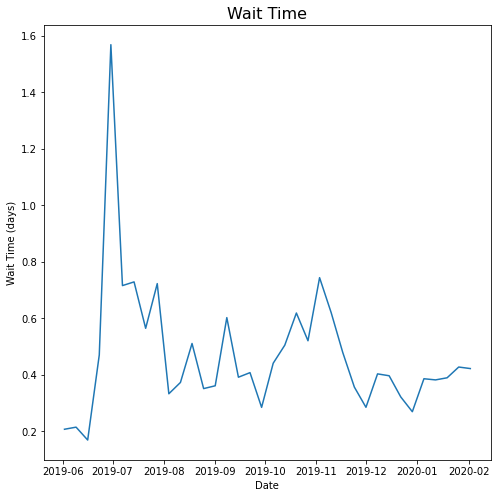

In [114]:
# Generate line plot of bus_ridership
plt.figure(figsize=(8,8))
plt.plot(ts_df['waittime']);
plt.title(label='Wait Time', fontsize = 16)
plt.xlabel("Date")
plt.ylabel("Wait Time (days)");

### Generalized Linear Model - Gamma Regression

In [120]:
train_index = X_train.index
test_index = X_test.index

In [121]:
r_sr = new_sr[new_features + ['waittime']]
r_train = r_sr.iloc[train_index]
r_test = r_sr.iloc[test_index]

In [128]:
glm_gamma_id = smf.glm(
    formula = "waittime ~ C(complaint_type) + C(descriptor) + C(location_type) + C(borough) + C(open_data_channel_type) + C(cluster_predicted)",
    data = r_train,
    family = sm.families.Gamma(link = sm.families.links.identity)
).fit()

/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  after removing the cwd from sys.path.
/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/statsmodels/genmod/generalized_linear_model.py:278: DomainWarning: The identity link function does not respect the domain of the Gamma family.
  DomainWarning)


In [129]:
glm_gamma_id.aic

1509199.586462353

In [130]:
glm_gamma_id.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               waittime   No. Observations:               404988
Model:                            GLM   Df Residuals:                   404891
Model Family:                   Gamma   Df Model:                           96
Link Function:               identity   Scale:                          46.834
Method:                          IRLS   Log-Likelihood:            -7.5450e+05
Date:                Tue, 02 Jun 2020   Deviance:                   8.8073e+05
Time:                        14:35:16   Pearson chi2:                 1.90e+07
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                            0.6018      0.873      0.689      0.491      -1.109       2.313
C(complaint_type)[T.Animal Abuse]                   -0.0043      0.125     -0.035      0.972      -0.249       0.240
C(complaint_type)[T.Animal-Abuse]                    0.0231      0.094      0.246      0.806      -0.161       0.207
C(complaint_type)[T.Bike/Roller/Skate Chronic]       0.0221      0.108      0.205      0.837      -0.189       0.233
C(complaint_type)[T.Blocked Driveway]                0.0574      0.052      1.106      0.269      -0.044       0.159
C(complaint_type)[T.Derelict Vehicle]               -0.9546      0.085    -11.188      0.000      -1.122      -0.787
C(complaint_type)[T.Disorderly Youth]               -0.0660      0.144     -0.457      0.647      -0.349       0.217
C(complaint_type)[T.Drinking]                        0.1910      0.414      0.462      0.644      -0.620       1.002
C(complaint_type)[T.Drug Activity]                   0.0173      0.082      0.211      0.833      -0.144       0.179
C(complaint_type)[T.Graffiti]                        0.0715      0.149      0.480      0.631      -0.221       0.364
C(complaint_type)[T.Homeless Encampment]             0.0555      0.081      0.682      0.495      -0.104       0.215
C(complaint_type)[T.Homeless Street Condition]      -0.0826      0.086     -0.963      0.336      -0.251       0.086
C(complaint_type)[T.Illegal Fireworks]              -0.0194      0.098     -0.198      0.843      -0.211       0.172
C(complaint_type)[T.Illegal Parking]                 0.0206      0.070      0.293      0.770      -0.117       0.159
C(complaint_type)[T.Noise - Commercial]             -0.0542      0.061     -0.886      0.376      -0.174       0.066
C(complaint_type)[T.Noise - House of Worship]        0.0116      0.294      0.039      0.969      -0.566       0.589
C(complaint_type)[T.Noise - Park]                   -0.0416      0.080     -0.517      0.605      -0.199       0.116
C(complaint_type)[T.Noise - Residential]            -0.0451      0.058     -0.775      0.438      -0.159       0.069
C(complaint_type)[T.Noise - Street/Sidewalk]        -0.0227      0.058     -0.394      0.693      -0.136       0.090
C(complaint_type)[T.Noise - Vehicle]                -0.1203      0.085     -1.414      0.157      -0.287       0.046
C(complaint_type)[T.Non-Emergency Police Matter]     0.0833      0.097      0.855      0.393      -0.108       0.274
C(complaint_type)[T.Panhandling]                    -0.0710      0.080     -0.893      0.372      -0.227       0.085
C(complaint_type)[T.Posting Advertisement]          -0.1252      0.112     -1.115      0.265      -0.345       0.095
C(complaint_type)[T.Squeegee]            

In [432]:
glm_gamma_id.aic

1509199.586462353

In [131]:
gamma_id_tr_preds = glm_gamma_id.predict(r_train)
gamma_id_te_preds = glm_gamma_id.predict(r_test)

In [132]:
print(f'Train:', rmse(y_train, gamma_id_tr_preds))
print(f'Test:', rmse(y_test, gamma_id_te_preds))
#print(f'Cross Val:', cross_val_score(SMWrapper(gamma_id), r_sr[new_features], r_sr['waittime'], scoring=make_scorer(rmse), cv=5).mean())
print(f'Difference: {rmse(y_test, gamma_id_te_preds) - rmse(y_train, gamma_id_tr_preds)}')

Train: 3.29427055662353
Test: 3.5348595813024453
Difference: 0.2405890246789153


In [36]:
# adapted from: https://nelsonauner.com/data/2018/05/21/wrap-statsmodels-in-sklearn.html
# and http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/glm.html

from sklearn.base import BaseEstimator, RegressorMixin

class SMFormulaWrapper(BaseEstimator, RegressorMixin):
    """ A sklearn-style wrapper for formula-based statsmodels regressors """
    def __init__(self, model_class, formula, family):
        self.model_class = model_class
        self.formula = formula
        self.family = family
    def fit(self, X, y=None):
        self.model_ = self.model_class(self.formula, data=X, family=self.family)
        self.results_ = self.model_.fit()
    def predict(self, X):
        return self.results_.predict(X)

In [38]:
import statsmodels.formula.api as smf
formula = "y ~ C(complaint_type) + C(descriptor) + C(location_type) + C(borough) + C(open_data_channel_type) + C(cluster_predicted)"
family = sm.families.Gamma(link = sm.families.links.identity)

cv_glm = cross_val_score(SMFormulaWrapper(smf.glm, formula, family), X=r_sr[new_features],y=r_sr['waittime'] , cv=3)

/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/statsmodels/genmod/generalized_linear_model.py:278: DomainWarning: The identity link function does not respect the domain of the Gamma family.
  DomainWarning)
/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/statsmodels/genmod/generalized_linear_model.py:278: DomainWarning: The identity link function does not respect the domain of the Gamma family.
  DomainWarning)
/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:697: RuntimeWarning: divide by zero encountered in true_divide
  endog_mu = self._clean(endog / mu)
/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:698: Runtime

In [39]:
cv_glm

array([0.08053258,        nan, 0.08566308])

In [37]:
formula = "y ~ C(complaint_type) + C(descriptor) + C(location_type) + C(borough) + C(open_data_channel_type) + C(cluster_predicted)"
family = sm.families.Gamma(link = sm.families.links.identity)

cv_glm2 = cross_val_score(SMFormulaWrapper(smf.glm, formula, family), X=r_sr[new_features], y=r_sr['waittime'],
                          scoring=make_scorer(rmse), cv=3)

cv_glm2

/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  
/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/statsmodels/genmod/generalized_linear_model.py:278: DomainWarning: The identity link function does not respect the domain of the Gamma family.
  DomainWarning)
/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/statsmodels/genmod/generalized_linear_model.py:278: DomainWarning: The identity link function does not respect the domain of the Gamma family.
  DomainWarning)
/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:697: RuntimeWarning: divide by zero encountered in true_divide
  endog_mu = self._clean(endog / mu)
/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:698: RuntimeWarning: divide by zero encountered in true_divide
  resid_dev = -np.log(endog_

array([3.15565413,        nan, 3.68461766])

In [439]:
gamma_id = smf.glm(
    formula = "waittime ~ C(complaint_type) + C(descriptor) + C(location_type) + C(borough) + C(open_data_channel_type) + C(cluster_predicted)",
    data = r_train,
    family = sm.families.Gamma(link = sm.families.links.identity)

/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  after removing the cwd from sys.path.
/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/statsmodels/genmod/generalized_linear_model.py:278: DomainWarning: The identity link function does not respect the domain of the Gamma family.
  DomainWarning)


In [440]:
print(f'Train:', rmse(y_train, gamma_id_tr_preds))
print(f'Test:', rmse(y_test, gamma_id_te_preds))
print(f'Cross Val:', cross_val_score(SMWrapper(gamma_id), r_sr[new_features], r_sr['waittime'], scoring=make_scorer(rmse), cv=5).mean())
print(f'Difference: {rmse(y_test, gamma_id_te_preds) - rmse(y_train, gamma_id_tr_preds)}')

Train: 3.29427055662353
Test: 3.5348595813024453


/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: 'GLM' object is not callable

  FitFailedWarning)


Cross Val: nan
Difference: 0.2405890246789153


In [122]:
glm_gamma_log = smf.glm(
    formula = "waittime ~ C(complaint_type) + C(descriptor) + C(location_type) + C(borough) + C(open_data_channel_type) + C(cluster_predicted)",
    data = r_train,
    family = sm.families.Gamma(link = sm.families.links.log)
).fit()

/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  after removing the cwd from sys.path.


In [123]:
glm_gamma_log.aic

1552203.770113084

In [124]:
glm_gamma_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               waittime   No. Observations:               404988
Model:                            GLM   Df Residuals:                   404891
Model Family:                   Gamma   Df Model:                           96
Link Function:                    log   Scale:                          49.656
Method:                          IRLS   Log-Likelihood:            -7.7600e+05
Date:                Tue, 02 Jun 2020   Deviance:                   8.7874e+05
Time:                        13:51:19   Pearson chi2:                 2.00e+07
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                         4.101e+11   3.72e+11      1.102      0.271    -3.2e+11    1.14e+12
C(complaint_type)[T.Animal Abuse]                -1.756e+10   7.79e+11     -0.023      0.982   -1.54e+12    1.51e+12
C(complaint_type)[T.Animal-Abuse]                -1.756e+10   7.79e+11     -0.023      0.982   -1.54e+12    1.51e+12
C(complaint_type)[T.Bike/Roller/Skate Chronic]   -1.295e+09   7.08e+11     -0.002      0.999   -1.39e+12    1.39e+12
C(complaint_type)[T.Blocked Driveway]            -1.555e+09      8e+10     -0.019      0.984   -1.58e+11    1.55e+11
C(complaint_type)[T.Derelict Vehicle]               -1.5412      0.219     -7.025      0.000      -1.971      -1.111
C(complaint_type)[T.Disorderly Youth]            -2.716e+11   2.44e+11     -1.111      0.267   -7.51e+11    2.08e+11
C(complaint_type)[T.Drinking]                    -4.101e+11   3.72e+11     -1.102      0.271   -1.14e+12     3.2e+11
C(complaint_type)[T.Drug Activity]               -3.955e+10   4.34e+11     -0.091      0.927   -8.89e+11     8.1e+11
C(complaint_type)[T.Graffiti]                    -2.728e+11   2.44e+11     -1.118      0.264   -7.51e+11    2.05e+11
C(complaint_type)[T.Homeless Encampment]         -1.295e+09   7.08e+11     -0.002      0.999   -1.39e+12    1.39e+12
C(complaint_type)[T.Homeless Street Condition]   -1.295e+09   7.08e+11     -0.002      0.999   -1.39e+12    1.39e+12
C(complaint_type)[T.Illegal Fireworks]           -1.295e+09   7.08e+11     -0.002      0.999   -1.39e+12    1.39e+12
C(complaint_type)[T.Illegal Parking]              9.007e+10   2.05e+11      0.439      0.660   -3.12e+11    4.92e+11
C(complaint_type)[T.Noise - Commercial]          -9.657e+10   3.09e+11     -0.312      0.755   -7.03e+11    5.09e+11
C(complaint_type)[T.Noise - House of Worship]    -9.657e+10   3.09e+11     -0.312      0.755   -7.03e+11    5.09e+11
C(complaint_type)[T.Noise - Park]                -9.657e+10   3.09e+11     -0.312      0.755   -7.03e+11    5.09e+11
C(complaint_type)[T.Noise - Residential]         -9.657e+10   3.09e+11     -0.312      0.755   -7.03e+11    5.09e+11
C(complaint_type)[T.Noise - Street/Sidewalk]     -9.657e+10   3.09e+11     -0.312      0.755   -7.03e+11    5.09e+11
C(complaint_type)[T.Noise - Vehicle]             -9.657e+10   3.09e+11     -0.312      0.755   -7.03e+11    5.09e+11
C(complaint_type)[T.Non-Emergency Police Matter] -1.756e+10   7.79e+11     -0.023      0.982   -1.54e+12    1.51e+12
C(complaint_type)[T.Panhandling]                 -1.295e+09   7.08e+11     -0.002      0.999   -1.39e+12    1.39e+12
C(complaint_type)[T.Posting Advertisement]       -2.708e+11   2.65e+11     -1.020      0.308   -7.91e+11    2.49e+11
C(complaint_type)[T.Squeegee]            

In [125]:
gamma_log_tr_preds = glm_gamma_log.predict(r_train)
gamma_log_te_preds = glm_gamma_log.predict(r_test)

In [126]:
print(f'Train:', rmse(y_train, gamma_log_tr_preds))
print(f'Test:', rmse(y_test, gamma_log_te_preds))
#print(f'Cross Val:', cross_val_score(SMWrapper(gamma_id), r_sr[new_features], r_sr['waittime'], scoring=make_scorer(rmse), cv=5).mean())
print(f'Difference: {rmse(y_test, gamma_log_te_preds) - rmse(y_train, gamma_log_tr_preds)}')

Train: 3.3756884154963034
Test: 3.5912634700457358
Difference: 0.21557505454943238


In [50]:
test_data = list(range(10))

In [51]:
list(range(11,21))

[11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [76]:
test_df = pd.DataFrame({'col1':test_data, 'col2':list(range(11,21)), 'col3': list(range(1,50,5))})

In [77]:
test_df

,col1,col2,col3
0,0,11,1
1,1,12,6
2,2,13,11
3,3,14,16
4,4,15,21
5,5,16,26
6,6,17,31
7,7,18,36
8,8,19,41
9,9,20,46


In [60]:
test_df.iloc[0:2]

,col1,col2
0,0,11
1,1,12


In [64]:
test_df.drop(index=list(range(0,2)))

,col1,col2
2,2,13
3,3,14
4,4,15
5,5,16
6,6,17
7,7,18
8,8,19
9,9,20


In [80]:
lr_test = LinearRegression()
lr_test.fit(test_df.iloc[0:7,0:2], test_df.iloc[0:7,2])
preds = lr_test.predict(test_df.iloc[7:,0:2])
rmse(test_df.iloc[7:,2], preds)

1.160311428702309e-14

In [ ]:
test_glm = smf.glm(
    formula = "waittime ~ C(complaint_type) + C(descriptor) + C(location_type) + C(borough) + C(open_data_channel_type) + C(cluster_predicted)",
    data = r_train,
    family = sm.families.Gamma(link = sm.families.links.log)
)

In [42]:
log_link = sm.families.links.log
identity_link = sm.families.links.identity
inverse_power_link = sm.families.links.inverse_power

In [38]:
def glm_cross_val(link, data):
    step = round(data.shape[0] / 5)
    scores = []
    for i in range(0, data.shape[0], step):
        fold = data.iloc[i:(i+step)]
        remainder = data.drop(index=list(range(i,i+step)))
        model = smf.glm(formula = "waittime ~ C(complaint_type) + C(descriptor) + C(cluster_predicted)",
                data = remainder,
                family = sm.families.Gamma(link=link)).fit()
        preds = model.predict(fold)
        score = rmse(fold['waittime'], preds)
        scores.append(score)
        print(score)
    return np.mean(scores)
        

In [99]:
test_r_sr = r_sr.iloc[0:100000]

In [ ]:
%%time
log_cv = glm_cross_val(log_link, r_sr)

/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  if __name__ == '__main__':


3.0746935918412452


/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  if __name__ == '__main__':


3.5883441474303237


/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  if __name__ == '__main__':


## SVR

In [ ]:
svr = SVR()

svr_params = {'kernel': ['linear'],
              'C' : [.1, 1, 5]}

 # Perform Grid Search
#gs = GridSearchCV(svr, # pipeline object replaces what we usually had as empty model class
                 param_grid=svr_params,
                 cv = 5,
                 scoring = make_scorer(rmse))
#svr = gs.fit(X_train, y_train)

In [ ]:
svr.best_params_

In [ ]:
svr_tr_preds = svr.predict(X_train)
svr_te_preds = svr.predict(X_test)

In [ ]:
print(f'Train:', rmse(y_train, svr_tr_preds))
print(f'Test:', rmse(y_test, svr_te_preds))
print(f'Cross Val:', cross_val_score(svr, X, y, scoring=make_scorer(rmse), cv=5).mean())
print(f'Difference: {rmse(y_test, svr_te_preds) - rmse(y_train, svr_tr_preds)}')